In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import math
import imageio

np.random.seed(42)
n_samples = 100_000


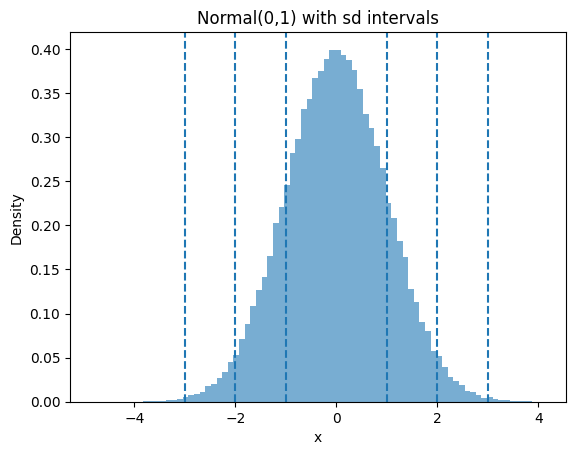

In [31]:

x = np.random.normal(0, 1, n_samples)
mu, sigma = np.mean(x), np.std(x)
plt.figure()
plt.hist(x, bins=80, density=True, alpha=0.6)
for k in [1, 2, 3]:
    plt.axvline(mu - k * sigma, linestyle="--")
    plt.axvline(mu + k * sigma, linestyle="--")
plt.title("Normal(0,1) with sd intervals")
plt.xlabel("x"); plt.ylabel("Density")
plt.show()

## The Pareto rule, or the 80/20 rule, is the observation that roughly 80% of effects come from 20% of causes. In this case it doesn't follow it since it is light-tailed distribution. If we use zipf then it changes to the specified 80% more or less 

In [32]:
p_geo = 0.2
geo = np.random.geometric(p_geo, n_samples)
def top20_share(arr):
    s = np.sort(arr)[::-1]
    top = int(0.2 * len(s))
    return np.sum(s[:top]) / np.sum(s)
share_geo = top20_share(geo)
print(f"Ex.2 — Geometric(p={p_geo}): Top 20% share ≈ {share_geo:.3f}")

Ex.2 — Geometric(p=0.2): Top 20% share ≈ 0.487


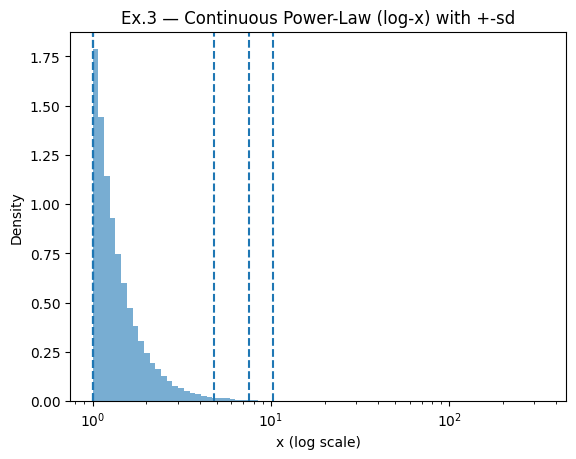

In [34]:
alpha, x_min = 3.0, 1.0
U = np.random.rand(n_samples)
pl = x_min * (1 - U) ** (-1/(alpha - 1))
mu_pl, sig_pl = np.mean(pl), np.std(pl)
bins = np.logspace(np.log10(x_min), np.log10(np.max(pl)), 80)
plt.figure()
plt.hist(pl, bins=bins, density=True, alpha=0.6)
for k in [1, 2, 3]:
    plt.axvline(max(x_min, mu_pl - k*sig_pl), linestyle="--")
    plt.axvline(mu_pl + k*sig_pl, linestyle="--")
plt.xscale("log")
plt.title("Ex.3 — Continuous Power-Law (log-x) with +-sd")
plt.xlabel("x (log scale)"); plt.ylabel("Density")
plt.show()

In [35]:
s_zipf = 2.0
zipf = np.random.zipf(s_zipf, n_samples)
share_zipf = top20_share(zipf)
print(f"Ex.4 — Zipf(s={s_zipf}): Top 20% share ≈ {share_zipf:.3f}")

Ex.4 — Zipf(s=2.0): Top 20% share ≈ 0.858


## BA - Lecture 2 51/76 slide, Erdos Renyl model The difference is in distribution, one follows normal, and the other continous power distribution 

mean        var  min  max  median
BA  5.982  52.765676    3   93     4.0
ER  6.038   6.224556    0   15     6.0

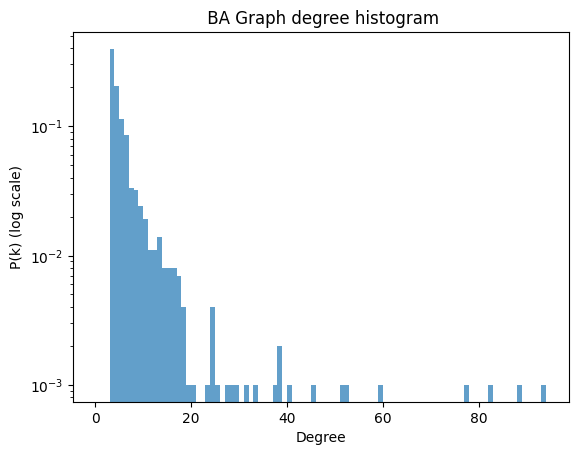

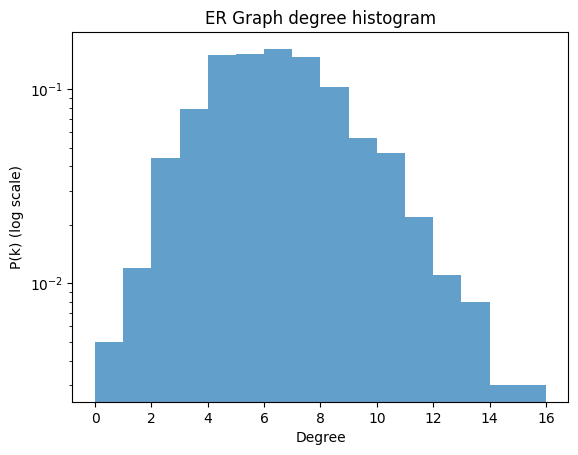

In [36]:
n, m = 1000, 3
G_ba = nx.barabasi_albert_graph(n, m, seed=42)
p_er = 2*m / (n-1)
G_er = nx.erdos_renyi_graph(n, p_er, seed=42)

deg_ba = np.array([d for _, d in G_ba.degree()])
deg_er = np.array([d for _, d in G_er.degree()])

def deg_stats(d):
    return dict(mean=np.mean(d), var=np.var(d), min=np.min(d),
                max=np.max(d), median=np.median(d))

df_stats = pd.DataFrame([deg_stats(deg_ba), deg_stats(deg_er)],
                        index=["BA", "ER"])
display(df_stats)

plt.figure()
plt.hist(deg_ba, bins=range(0, int(deg_ba.max())+2), density=True, alpha=0.7)
plt.yscale("log")
plt.title(" BA Graph degree histogram")
plt.xlabel("Degree"); plt.ylabel("P(k) (log scale)")
plt.show()

plt.figure()
plt.hist(deg_er, bins=range(0, int(deg_er.max())+2), density=True, alpha=0.7)
plt.yscale("log")
plt.title("ER Graph degree histogram")
plt.xlabel("Degree"); plt.ylabel("P(k) (log scale)")
plt.show()

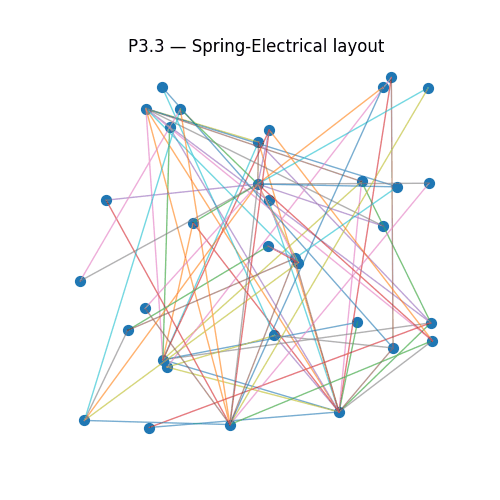

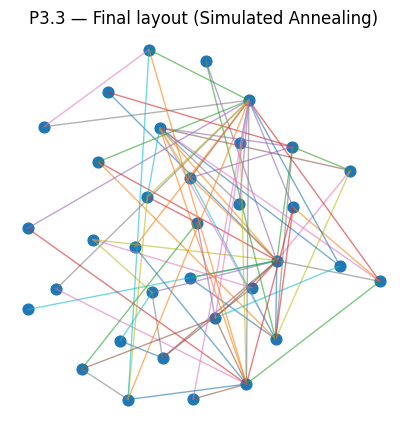

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import imageio
from matplotlib.backends.backend_agg import FigureCanvasAgg
from IPython.display import Image, display

G = nx.karate_club_graph()
rng = np.random.default_rng(123)
pos = {i: rng.random(2) for i in G.nodes()}
k_e, k_s, L0 = 1.0, 0.1, 0.3
T0, T_end, max_iter, rec_every = 0.1, 1e-3, 1500, 15

def total_energy(p):
    Erep = 0
    nodes = list(p.keys())
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            r = np.linalg.norm(p[nodes[i]] - p[nodes[j]]) + 1e-9
            Erep += k_e / r
    Espring = sum(0.5*k_s*(np.linalg.norm(p[u]-p[v]) - L0)**2 for u,v in G.edges())
    return Erep + Espring

def temp(t): return T0*((T_end/T0)**(t/max_iter))

frames, E = [], total_energy(pos)
frames.append({k:v.copy() for k,v in pos.items()})
for t in range(1, max_iter+1):
    T = temp(t)
    cand = {k:(v + rng.normal(0, T, 2)) for k,v in pos.items()}
    Enew = total_energy(cand)
    if Enew < E or rng.random() < math.exp(-(Enew-E)/max(T,1e-12)):
        pos, E = cand, Enew
    if t % rec_every == 0:
        frames.append({k:v.copy() for k,v in pos.items()})

images = []
for f in frames:
    fig, ax = plt.subplots(figsize=(5,5))
    canvas = FigureCanvasAgg(fig)
    for u,v in G.edges():
        ax.plot([f[u][0], f[v][0]], [f[u][1], f[v][1]], lw=1, alpha=0.6)
    xs = [f[n][0] for n in G.nodes()]
    ys = [f[n][1] for n in G.nodes()]
    ax.scatter(xs, ys, s=50)
    ax.axis("off"); ax.set_title("Spring-Electrical layout")
    canvas.draw()
    img = np.asarray(canvas.buffer_rgba())[:, :, :3]
    images.append(img)
    plt.close(fig)

gif = "p3_3_layout.gif"
imageio.mimsave(gif, images, duration=0.06)
display(Image(filename=gif))

plt.figure(figsize=(5,5))
for u,v in G.edges():
    plt.plot([pos[u][0], pos[v][0]], [pos[u][1], pos[v][1]], lw=1, alpha=0.6)
xs = [pos[n][0] for n in G.nodes()]
ys = [pos[n][1] for n in G.nodes()]
plt.scatter(xs, ys, s=60)
plt.axis("off")
plt.title("P3.3 — Final layout ")
plt.show()

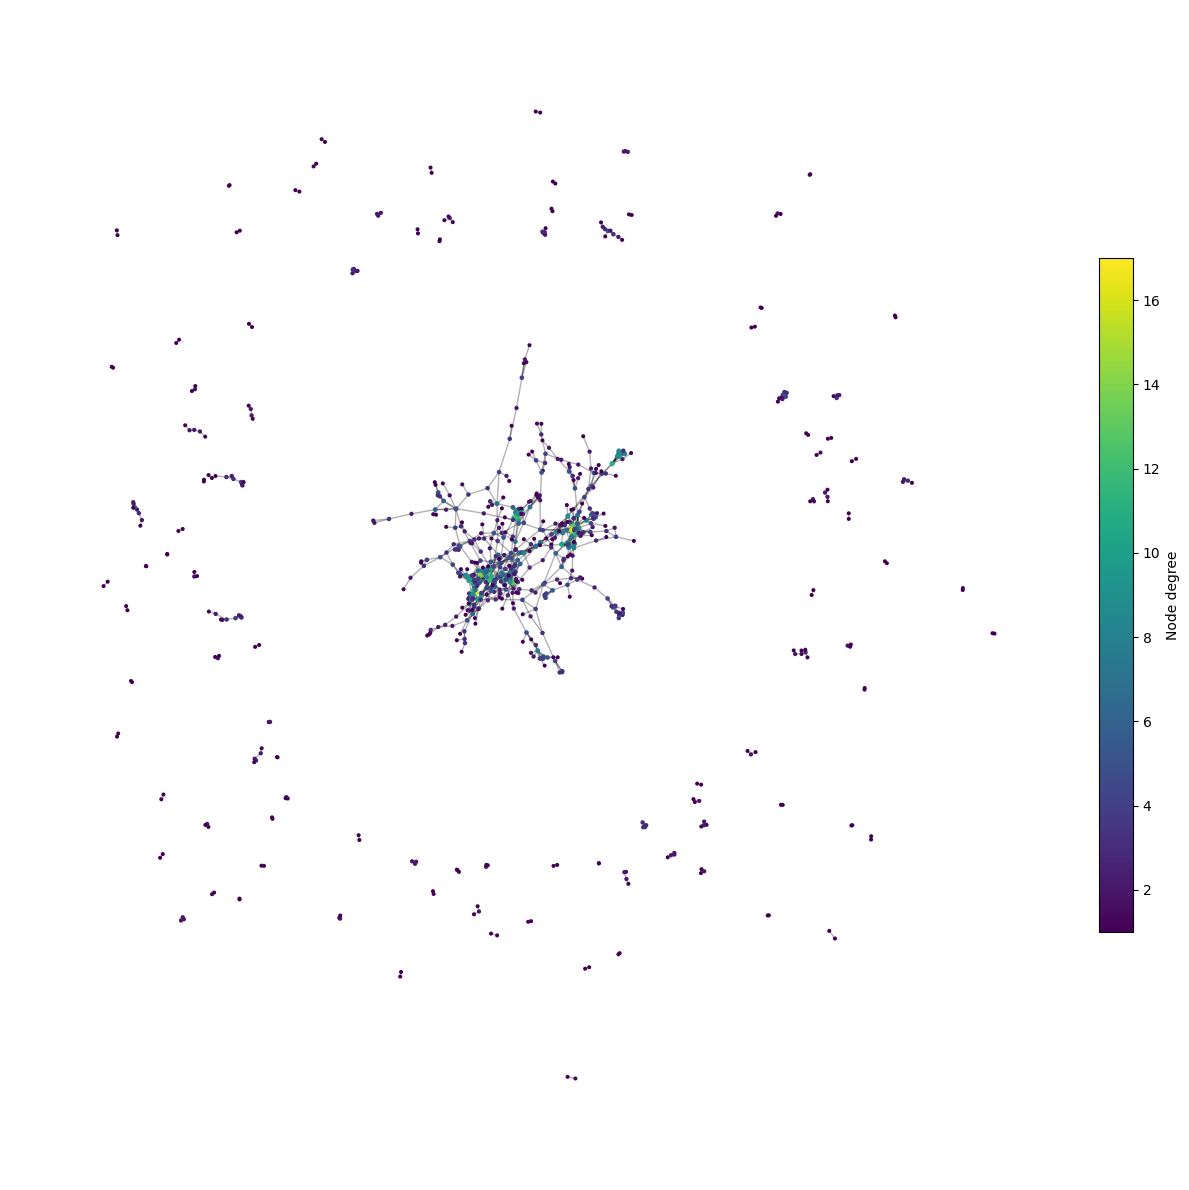

In [19]:
import networkx as nx 
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

G = nx.read_edgelist(
    "networks/reptilia-tortoise-network-fi/reptilia-tortoise-network-fi.edges", 
    create_using=nx.Graph(), 
    nodetype=int, 
    comments="%",
    data=(("weight", float),)
)

pos = nx.spring_layout(G, seed=42)

deg = dict(G.degree())
dvals = np.array([deg[n] for n in G.nodes()])
sizes = 6 + 2.5*np.sqrt(dvals)

fig, ax = plt.subplots(figsize=(12, 12))

nx.draw_networkx_edges(G, pos, ax=ax, width=1, alpha=0.3)

nodes = nx.draw_networkx_nodes(
    G, pos, ax=ax,
    node_size=sizes,
    node_color=dvals,
    cmap=plt.cm.viridis,
    linewidths=0
)

norm = Normalize(vmin=dvals.min(), vmax=dvals.max())
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis),
                    ax=ax, fraction=0.03, pad=0.01)
cbar.set_label("Node degree")

ax.set_axis_off()
plt.tight_layout()
plt.show()

## taken from tasks2 but adjusted and added new layouts 

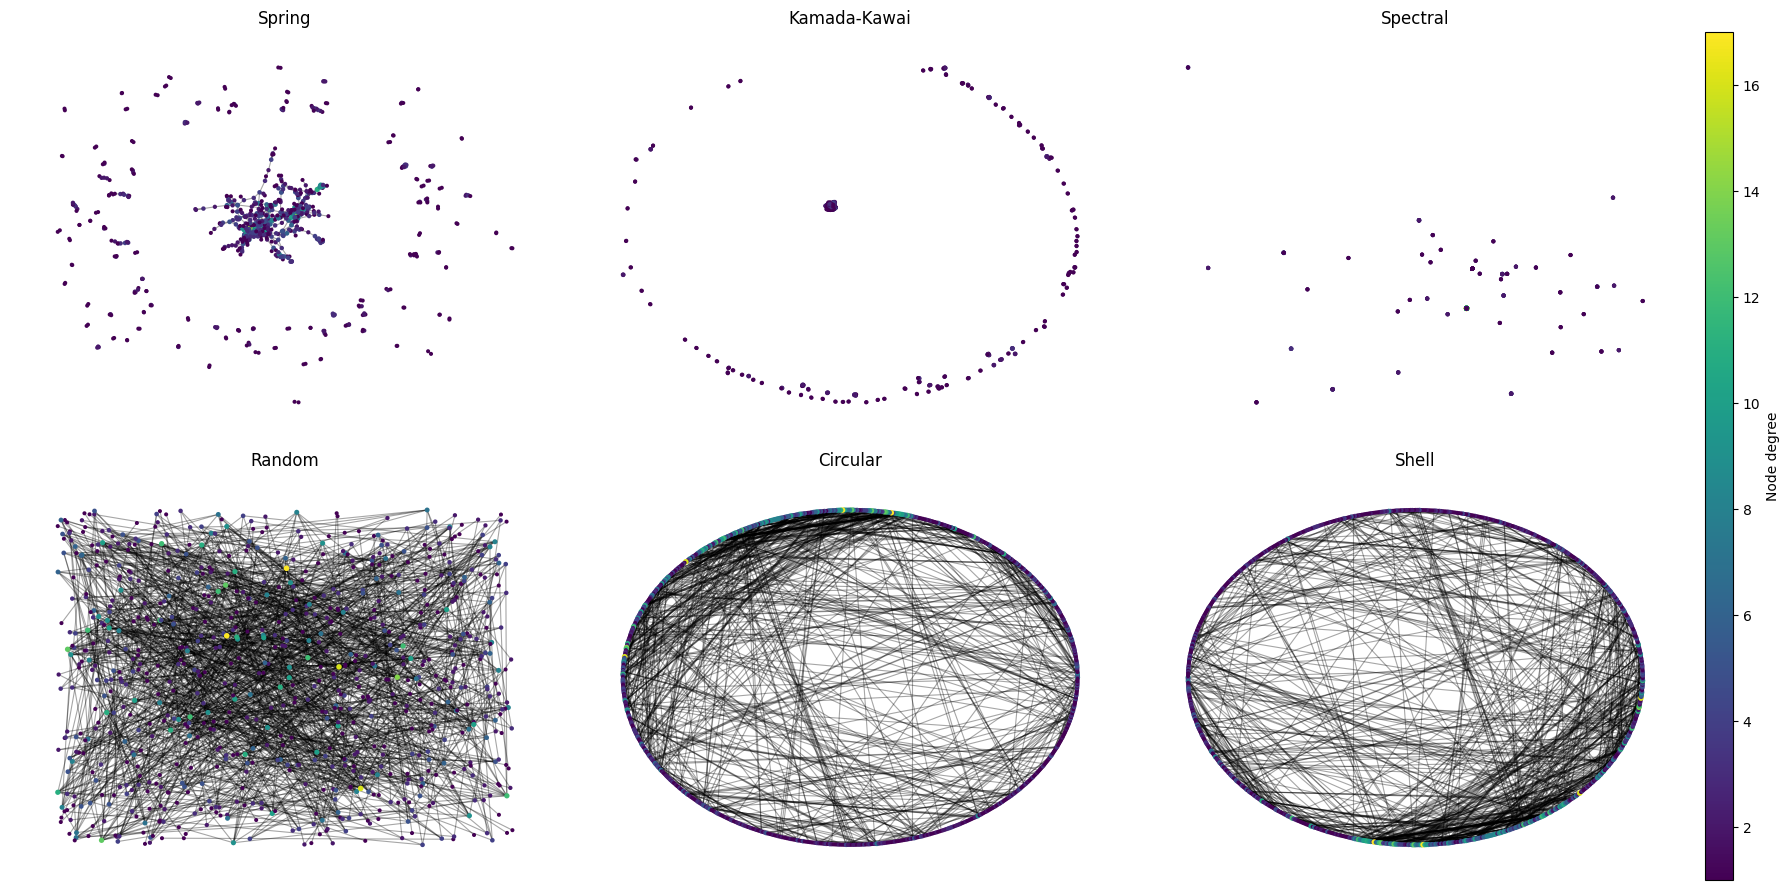

In [30]:
import networkx as nx 
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec
import numpy as np

G = nx.read_edgelist(
    "networks/reptilia-tortoise-network-fi/reptilia-tortoise-network-fi.edges", 
    create_using=nx.Graph(), 
    nodetype=int, 
    comments="%",
    data=(("weight", float),)
)

deg = dict(G.degree())
dvals = np.array([deg[n] for n in G.nodes()])
sizes = 6 + 2.5*np.sqrt(dvals)

layout_funcs = [
    ("Spring", lambda G: nx.spring_layout(G, seed=42)),
    ("Kamada-Kawai", nx.kamada_kawai_layout),
    ("Spectral", lambda G: nx.spectral_layout(G)),
    ("Random", lambda G: nx.random_layout(G, seed=42)),
    ("Circular", nx.circular_layout),
    ("Shell", nx.shell_layout)
]

layouts = [(title, fn(G)) for title, fn in layout_funcs]

fig = plt.figure(figsize=(18, 9))
gs = gridspec.GridSpec(2, 4, width_ratios=[1, 1, 1, 0.05])
axes = [fig.add_subplot(gs[i//3, i%3]) for i in range(6)]
cax = fig.add_subplot(gs[:, 3])

norm = Normalize(vmin=dvals.min(), vmax=dvals.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis)

for ax, (title, pos) in zip(axes, layouts):
    nx.draw_networkx_edges(G, pos, ax=ax, width=0.8, alpha=0.35)
    nx.draw_networkx_nodes(
        G, pos, ax=ax,
        node_size=sizes,
        node_color=dvals,
        cmap=plt.cm.viridis,
        linewidths=0
    )
    ax.set_title(title)
    ax.set_axis_off()

cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("Node degree")

plt.tight_layout()
plt.show()


Six common layouts are shown: Spring and Kamada–Kawai reveal community-like clusters via force models; Spectral uses eigenvectors of the Laplacian for a smooth embedding, while Random provides a baseline. Circular places nodes on a ring to expose chord structure, and Shell arranges nodes in concentric rings
